# 1. <a id='toc1_'></a>[RIPV Autodiff Experiments](#toc0_)

In [2]:
import numpy as np
from scipy import integrate, linalg
import qutip as q
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.linalg import expm
from tqdm import tqdm
from matplotlib import cm
import matplotlib as mpl
import pickle

plt.rcParams['figure.figsize'] = (3, 2)
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
np.set_printoptions(precision=3, linewidth=500, suppress=False)

**Table of contents**<a id='toc0_'></a>    
- 1. [RIPV Autodiff Experiments](#toc1_)    
  - 1.1. [Recover Hai's pulses](#toc1_1_)    
  - 1.2. [Ensure recovery success](#toc1_2_)    
  - 1.3. [Pulse parametrization](#toc1_3_)    
  - 1.4. [Fidelity](#toc1_4_)    
  - 1.5. [Robustness for 2d error curve](#toc1_5_)    
  - 1.6. [Evolution functions](#toc1_6_)    
  - 1.7. [Control models](#toc1_7_)    
  - 1.8. [M1 matrix to error curve](#toc1_8_)    
      - 1.8.1.1. [Test curve function](#toc1_8_1_1_)    
  - 1.9. [Computing the net area](#toc1_9_)    
    - 1.9.1. [Through curve points](#toc1_9_1_)    
    - 1.9.2. [Compare net area calculations](#toc1_9_2_)    
      - 1.9.2.1. [Calculate net area from *analytical* curve](#toc1_9_2_1_)    
      - 1.9.2.2. [Calculate net area from *numerical* curve: M1_t projected to Pauli basis](#toc1_9_2_2_)    
      - 1.9.2.3. [Calculate net area using matrix commutator](#toc1_9_2_3_)    
    - 1.9.3. [Gradient Orthogonal Variation       ](#toc1_9_3_)    
      - 1.9.3.1. [Orthogonalize ](#toc1_9_3_1_)    
      - 1.9.3.2. [GOV generic form  ](#toc1_9_3_2_)    
  - 1.10. [Read $X_{1/2 \pi}$ pulse](#toc1_10_)    
  - 1.11. [Read R2=0 pulse](#toc1_11_)    
  - 1.12. [Vary Hai's pulse with R1 fixed](#toc1_12_)    
  - 1.13. [Vary Hai's pulse with R1 R2 fixed](#toc1_13_)    
    - 1.13.1. [Plot fidelity vs noise Rx Gate](#toc1_13_1_)    
      - 1.13.1.1. [3D plottings](#toc1_13_1_1_)    
    - 1.13.2. [Plot fidelity vs detuning in iSWAP](#toc1_13_2_)    
    - 1.13.3. [Animation](#toc1_13_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1.1. <a id='toc1_1_'></a>[Recover Hai's pulses](#toc0_)

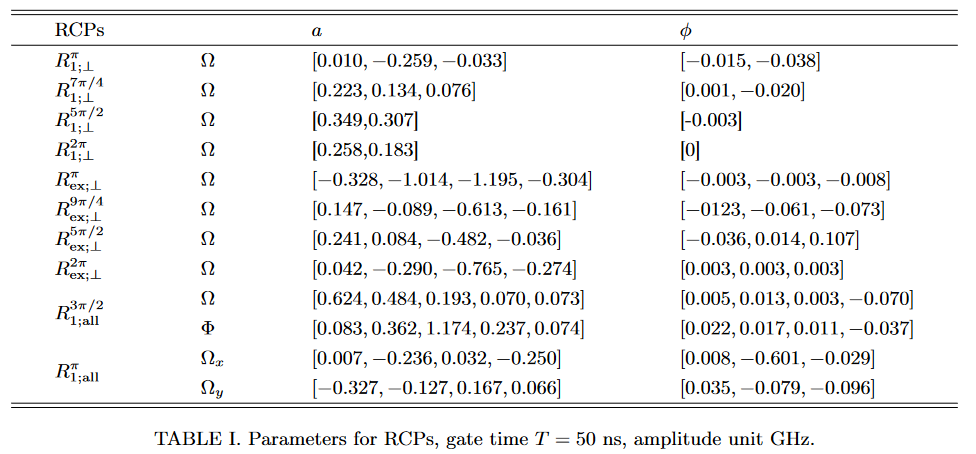

$$
\begin{aligned}
&\Omega_0(a_j,\phi_j;t) =\sin\biggl(\frac{\pi t}{T}\biggr)\left(a_0+\sum_{j=1}^na_j\cos\biggl(\frac{2\pi j}{T}t+\phi_j\biggr)\right)  \\
&\Phi_0(b_j,\psi_j;t) =b_0+\sum_{j=1}^nb_j \cos\left(\frac{2\pi j}Tt+\psi_j\right), 
\end{aligned}
$$

In [4]:
def hai_paramsToPulse(tlist, amps, phases, sinEnvelope=False):
    """
    Test version. Return numpy array
    """
    raise Exception('Should not use this test function')
    n = len(phases)
    T = tlist[-1] - tlist[0]
    t = tlist
    assert len(amps) == n + 1
    
    pulse = np.ones(t.shape) * amps[0]
    for a, phi, j in zip(amps[1:], phases, range(1, n+1)):
        pulse = pulse + a * np.cos(2*np.pi * j * t / T + phi)
    if sinEnvelope:
        pulse = pulse * np.sin(t / T * np.pi)
    return pulse

In [5]:
class HaiPulse:
    def __init__(self, tlist) -> None:
        self.tlist = tlist
    
    def fromParams(self, p) -> tf.Tensor:
        """
        p: Tensor[2n+1,]
        where p[:n+1] are amplitudes
        p[n+1:] are phases
        """
        t = self.tlist
        T = t[-1] - t[0]
        n = (p.shape[0] - 1) // 2

        a, phi = p[:n+1], p[n+1:]
        j = tf.range(1.0, n+1, dtype=tf.float64)  # j = 1, ..., n

        t = tf.expand_dims(t, axis=0)       # t dim   [1, len_t]
        j = tf.expand_dims(j, axis=1)       # j dim   [n, 1]         where n = len_phi + len_a
        phi = tf.expand_dims(phi, axis=1)   # phi dim [n, 1] 
        a = tf.expand_dims(a, axis=1)       # a dim   [n + 1, 1]

        components = a[1:] * tf.cos(2 * np.pi * j * t / T + phi)

        pulse = (a[0] + tf.reduce_sum(components, axis=0)) * tf.sin(t / T * np.pi)
        pulse = tf.squeeze(pulse)
        pulse = tf.cast(pulse, tf.complex128)
        return pulse

## 1.2. <a id='toc1_2_'></a>[Ensure recovery success](#toc0_)

In [6]:
# loadPulse = np.loadtxt('../RCP_data/RCP_ex_2pi.csv')

In [7]:
# tlist = np.linspace(0, 50, 501)
# a, phi = [0.042, -0.290, -0.765, -0.274], [0.003, 0.003, 0.003]

In [8]:
# tfPulse = HaiPulse(tlist).fromParams(tf.convert_to_tensor(a + phi, dtype=tf.float64))
# tfPulse.shape

In [9]:
# paramPulse = hai_paramsToPulse(tlist, a, phi, sinEnvelope=True)
# plt.plot(tlist, paramPulse, label='calculated')
# plt.plot(tlist, loadPulse, label='loaded')
# plt.plot(tlist, tfPulse, label='tf')
# plt.legend()
# plt.show()

# np.max(np.abs(paramPulse - loadPulse)), np.max(np.abs(tfPulse - loadPulse))

## 1.3. <a id='toc1_3_'></a>[Pulse parametrization](#toc0_)

In [10]:
class OldVersionMorlet:
    def __init__(self, nChannel, s=25, center_to_s=3.7, t_segments=1024):
        """
        basis: Tensor[nChannels, nTime]
        """
        self.nChannel = nChannel
        self.tlist = None
        self.basis = self._morlet_basis(nChannel, s, center_to_s, t_segments)

    def _morlet_basis(self, nChannel, s=25, center_to_s=3.7, t_segments=1024):
        """
        `s`: standard deviation of gauss envolope, in units of seconds
        `center_to_s`: center of sampling period, in units of s
        `t_segments`: number of time segments
        return: channels, tlist
        """

        center = center_to_s * s
        self.tlist = np.linspace(0, center * 2, t_segments + 1)

        t1 = (self.tlist - center) / s  # normalized
        gauss = np.exp(-1/2 * t1**2)
        channels = [np.cos(omega * t1) * gauss for omega in range(nChannel)]
        channels = [c / c.max() for c in channels]
        channels = tf.convert_to_tensor(channels)
        return channels

    def fromAmplitudes(self, A):
        """
        return: Ω(t; A)
        """
        A = tf.expand_dims(A, axis=0)
        pulse = A @ self.basis
        pulse = tf.squeeze(pulse, axis=0)
        pulse = tf.cast(pulse, tf.complex128)
        return pulse

## 1.4. <a id='toc1_4_'></a>[Fidelity](#toc0_)

In [11]:
def matrix_similarity(a, b, measure_type='Pederson fidelity'):
    if isinstance(a, q.Qobj):
        a = a.full()
    if isinstance(b, q.Qobj):
        b = b.full()
    def Pederson_fidelity(a, b):
        M = a.conj().T @ b
        Md = M.conj().T
        n = M.shape[0]
        return 1/(n*(n+1)) * (np.trace(M @ Md).real + np.abs(np.trace(M)) ** 2)
        
    type2func = {
        'inner product as infidelity':
            lambda a, b: (len(a) - np.trace(a.conj().T @ b)) / len(a),
        'tracedist':
            lambda a, b: q.tracedist(q.Qobj(a), q.Qobj(b)),
        'inner product':
            lambda a, b: np.abs(np.trace(a.conj().T @ b)) / len(a),
        'Pederson fidelity':
            Pederson_fidelity,
        'fro':
            lambda a, b: np.linalg.norm(a-b, 'fro'),
    }
    func = type2func[measure_type]
    d = func(a, b)
    return d

## 1.5. <a id='toc1_5_'></a>[Robustness for 2d error curve](#toc0_)

In [12]:
def indef_integrate_matrix(x, method='trapezoid', islinspace=True):
    """
    This function applies to not evenly spaced x
    """
    N = len(x)
    x = np.array(x)
    if islinspace:
        dx = (x[-1] - x[0]) / (len(x) - 1)
        oneslower = np.tril(np.ones(shape=(N, N)), k=-1)
        if method == 'simple' or method == 's':
            A = oneslower
        elif method == 'trapezoid' or method == 't':
            head = np.zeros(shape=(1, N))
            head[0, 0] = 1
            tail = np.diag(np.ones(shape=(N)))
            A = dx * (oneslower - head / 2 + tail / 2)
            # print(f'{oneslower=}\n{head=}\nn{tail=}\n{A=}')
        else:
            raise Exception('`method` can only be "trapezoid" or "simple')
    else:
        dx = x[1:] - x[:-1]  # len=N-1
        # print(f"{dx=}")

        def row_trapz(i):
            dx_firsti = dx[:i]  # len=i
            dx_trapz = np.concatenate([[0], dx_firsti]) / 2 + \
                np.concatenate([dx_firsti, [0]]) / 2  # len=i+1
            row = np.concatenate([dx_trapz, [0] * (N-i-1)])  # len=[i+1, N-i-1]
            return row
        def row_simple(i):
            return np.concatenate([dx[:i], [0] * (N-i)])
        
        if method == "trapezoid" or method == 't':
            A = np.array([row_trapz(i) for i in range(N)])
        elif method == "simple" or method == 's':
            A = np.array([row_simple(i) for i in range(N)])
        else:
            raise Exception('`method` can only be "trapezoid" or "simple')
    return A

indef_integrate_matrix(x = [.1, .2, .38, .5], islinspace=False)
indef_integrate_matrix(x=np.arange(5), islinspace=True)

array([[0. , 0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0. , 0. , 0. ],
       [0.5, 1. , 0.5, 0. , 0. ],
       [0.5, 1. , 1. , 0.5, 0. ],
       [0.5, 1. , 1. , 1. , 0.5]])

In [13]:
def fast_robustness(kappa, tlist, A=None):
    if A is None:
        A = indef_integrate_matrix(tlist)
    K = A @ kappa

    # Use simpson to ensure A yields correct endpoint
    x, y = (
        integrate.simpson(np.cos(K), x=tlist),
        integrate.simpson(-np.sin(K), x=tlist)
    )
    return np.sqrt(x**2 + y**2)



def get_curve_fast(kappa, tlist):
    """
    return: x, y: np.array
    """
    A = indef_integrate_matrix(tlist)
    K = A @ kappa

    # Use simpson to ensure A yields correct endpoint
    x, y = A @ np.cos(K), A @ (- np.sin(K))
    return x, y

In [14]:
# fast_robustness(loadPulse, tlist), fast_robustness(paramPulse, tlist), fast_robustness(np.array(tfPulse), tlist)

Magnus expansion

In Hai's:
$$
\mathrm{T}\cdot\hat{\boldsymbol{\sigma}}=U_0^\dagger(t)\sigma_zU_0(t)
$$

$$
\begin{aligned}
&U_{I}(t)=I-i\delta_{j}A_{1}^{j}-[\frac{1}{2}(\delta_{j}A_{1}^{j})^{2}+i\delta_{j}\delta_{k}A_{2}^{jk}]+O(\delta^{3}),\\
&\text{where}\\
&
\left\{
    \begin{array}{c}
    A_{1}^{j}(t)=\int_{0}^{\tau}du(\mathbf{T}_{j}\cdot\hat{\boldsymbol{\sigma}})\\
    A_{2}^{jk}(t)=\frac{1}{2}\int_{0}^{t}d\tau[\dot{A}_{1}^{j}(t),A_{1}^{k}(t)]\\
    A_{n+1}^{jkl...}(t)=\frac{1}{2}\int_{0}^{t}d\tau[\dot{A}_{n}^{j}(t),A_{n}^{kl...}(t)].
    \end{array}
\right.
\end{aligned}
$$

My $M_1(t)$ is $\dot{A}_{1}^{j}(t)=\mathrm{T}\cdot\hat{\boldsymbol{\sigma}}=U_0^\dagger(t)\sigma_zU_0(t)$.

## 1.6. <a id='toc1_6_'></a>[Evolution functions](#toc0_)

In [ ]:
def construct_H_c(coeffs, H_c_terms) -> tf.Tensor:
    """
    coeffs: Tensor[nCtrl, nTime]
    H_c_terms: Tensors[nCtrl, d, d]
    return: Tensor[nTime, d, d]
    """
    # Expand coeffs [nCtrl, nTime] → [nCtrl, nTime, 1, 1]
    coeffs_expanded = tf.expand_dims(tf.expand_dims(coeffs, axis=-1), axis=-1)

    # Expand H_c_terms [nCtrl, d, d] → [nCtrl, 1, d, d]
    H_c_terms_expanded = tf.expand_dims(H_c_terms, axis=1)

    # Element-wise multiplication, then summing over the control dimension
    H_c = tf.reduce_sum(coeffs_expanded * H_c_terms_expanded, axis=0)
    # H_c now has shape [nTime, d, d]
    
    return H_c

propagator of H(t)

In [16]:
def propagator_of_Ht(Ht, tlist=None, dt=None) -> tf.Tensor:
    """
    Ht: Tensor[nTime, d, d]
    optional parameters, choose either one:
        tlist: Tensor[nTime,]
        dt: scalar
    """
    assert (tlist is None) != (dt is None)  # one and only one is None
    nTime, d, _ = Ht.shape

    if tlist is not None:
        dt = tlist[1:] - tlist[:-1]  # shape=(nTime-1,)
        dt = tf.expand_dims(tf.expand_dims(dt, axis=1), axis=2)
    dU = tf.linalg.expm(-1j * Ht[:-1] * dt)

    # This is not cumulative product as U = tf.math.cumprod(dU, axis=0)
    # Instead, we do cumulative __matrix__ product
    Ut = [None] * nTime
    Ut[0] = tf.eye(d, dtype=Ht.dtype)
    for i in range(nTime - 1):
        Ut[i + 1] = dU[i] @ Ut[i]
    Ut = tf.convert_to_tensor(Ut)
    return Ut

Interaction picture

In [17]:
def interaction_picture(H: tf.Tensor, U_0: tf.Tensor) -> tf.Tensor:
    """
    H: Tensor[nTime, d, d] or [d, d]
    U_0: Tensor[nTime, d, d]
    return: Tensor[nTime, d, d]
        H_I[k] = U_0[k]^† H[k] U_0[k]
    """
    if len(H.shape) == 2:  # H: Tensor[d, d] is time-independent
        H = tf.expand_dims(H, axis=0)  # H.shape: (d, d) -> (1, d, d)
    H_I = tf.matmul(U_0, H, adjoint_a=True) @ U_0
    return H_I

Naive integral on t

In [18]:
def simpleIntegral(y: tf.Tensor, x=None, dx=None, axis=0) -> tf.Tensor:
    """
    Only support axis=0 now
    Definite integral
    y: Tensor[nTime, *shape]
    x: Tensor[nTime,]
    return: [*shape], one y value
        = ∫_x[0]^x[-1] y dx
    """
    assert axis == 0
    if x is not None:
        dx = x[1:] - x[:-1]
        # shape should be [nTimeSlices, 1(repeat d-1)] if y is rank-d tensor
        rank_y = len(y.shape)
        shape = (len(dx),) + (1,) * (rank_y - 1)
        dx = tf.reshape(dx, shape)
        I = tf.math.reduce_sum(y[:-1] * dx, axis=axis)
    elif dx is not None:
        # Assuming the pulse is 1d array
        I = tf.math.reduce_sum(y[:-1] * dx, axis=axis)
    else:
        raise Exception('Either x or dx must be passed with name')
    return I

In [19]:
def simpleCumulativeIntegral(yOfx, y0, x, axis=0) -> tf.Tensor:
    """
    Indefinite integral
    yOfx: Tensor[nTime, *y0.shape], values at corresponding x
    y0: initial value
    x: Tensor[nTime,]
    axis: only support axis=0
    return: Tensor[nTime, *y0.shape], array of y values
        = y0 + ∫_x[0]^x yOfx dx
    """
    assert axis == 0
    I = [None] * len(x)
    I[0] = y0
    dx = x[1:] - x[:-1]
    for i in range(len(dx)):
        # ∫_0^{x+dx} = ∫_0^x + y(x) * dx
        I[i + 1] = I[i] + yOfx[i] * dx[i]
    I = tf.stack(I)
    return I

## 1.7. <a id='toc1_7_'></a>[Control models](#toc0_)

In [ ]:
class SingleControlModel:
    """
    This model defines how to control a system with pulse parameters.
    I.e. the following map:
        pulse parameters -> (rotation angle, robustness)
    """
    def __init__(self, tlist, H_sys, H_c_terms, H_n, paramsToSinglePulse) -> None:
        self.tlist = tlist
        self.dt = (tlist[-1] - tlist[0]) / len(tlist)
        self.H_sys = H_sys
        self.H_c_terms = H_c_terms
        self.H_n = H_n
        self.paramsToPulse = paramsToSinglePulse
        self.pulse = None
        self.H_I_t = None
        self.M1_t = None
        self.M2_T = None

    def setPulse(self, pulse):
        self.pulse = pulse

    def angleAndRobustness(self, A):
        """
        This function implements `CostAndConstraint`:
            f(A) -> {x, cost, cons, ...}
        """
        pulse = self.paramsToPulse(A)
        self.setPulse(pulse)
        theta = simpleIntegral(pulse, x=self.tlist)
        M1_t = self.get_M1_t()

        R1 = tf.norm(M1_t[-1])
        R1 = tf.expand_dims(R1, axis=0) # R1.shape = (nCons,)
        result = {
            'cost': theta,
            'cons': R1,
            'M1_t': M1_t,
            'H_I_t': self.H_I_t
        }
        return result

    def angleAndR1R2(self, A):
        pulse = self.paramsToPulse(A)
        self.setPulse(pulse)
        theta = simpleIntegral(pulse, x=self.tlist)
        M1_t = self.get_M1_t()

        R1 = tf.norm(M1_t[-1])
        M2_T = self.get_M2_T()
        R2 = tf.norm(M2_T)
        R1R2 = tf.stack([R1, R2])
        result = {
            'cost': theta,
            'cons': [R1, R2],
            'M1_t': M1_t,
            'H_I_t': self.H_I_t
        }
        return result
    
    def get_M1_t(self):
        assert self.pulse is not None
        pulse = self.pulse
        H_c = construct_H_c([pulse / 2], self.H_c_terms)
        H_noiseFree_t = self.H_sys + H_c
        U_noiseFree_t = propagator_of_Ht(H_noiseFree_t, dt=self.dt)

        H_I_t = interaction_picture(self.H_n, U_noiseFree_t)
        M1_t = simpleCumulativeIntegral(H_I_t, tf.convert_to_tensor(q.identity(2).full()), self.tlist)
        self.M1_t = M1_t
        self.H_I_t = H_I_t
        return M1_t
    
    def get_M2_T(self) -> tf.Tensor:
        """
        M2(t) = 1/2 ∫_0^t [H_I(t), M1(t)] dt
        """
        if self.M1_t is None:
            self.get_M1_t()
        H_I_t, M1_t = self.H_I_t, self.M1_t
        commutator = H_I_t @ M1_t - M1_t @ H_I_t
        M2_T = 1/4 * simpleIntegral(commutator, self.tlist, axis=0)
        self.M2_T = M2_T
        return M2_T

## 1.8. <a id='toc1_8_'></a>[M1 matrix to error curve](#toc0_)

In [21]:
def projectToPauli(M1_t: tf.Tensor):
    """
    return x, y, z
    each being a real part np.array
    """
    x, y, z = (
        1/2 * tf.linalg.trace(M1_t @ tf.convert_to_tensor(q.sigmax().full())),
        1/2 * tf.linalg.trace(M1_t @ tf.convert_to_tensor(q.sigmay().full())),
        1/2 * tf.linalg.trace(M1_t @ tf.convert_to_tensor(q.sigmaz().full())),
    )
    # x, y, z = np.array(x).real, np.array(y).real, np.array(z).real
    return x, y, z

In [ ]:
class SingleControlModel:
    """
    This model defines how to control a system with pulse parameters.
    I.e. the following map:
        pulse parameters -> (rotation angle, robustness)
    """
    def __init__(self, tlist, H_sys, H_c_terms, H_n, paramsToSinglePulse) -> None:
        self.tlist = tlist
        self.dt = (tlist[-1] - tlist[0]) / len(tlist)
        self.H_sys = H_sys
        self.H_c_terms = H_c_terms
        self.H_n = H_n
        self.paramsToPulse = paramsToSinglePulse
        self.pulse = None
        self.H_I_t = None
        self.M1_t = None
        self.M2_T = None

    def setPulse(self, pulse):
        self.pulse = pulse

    def angleAndRobustness(self, A):
        """
        This function implements `CostAndConstraint`:
            f(A) -> {x, cost, cons, ...}
        """
        pulse = self.paramsToPulse(A)
        self.setPulse(pulse)
        theta = simpleIntegral(pulse, x=self.tlist)
        M1_t = self.get_M1_t()

        R1 = tf.norm(M1_t[-1])
        R1 = tf.expand_dims(R1, axis=0) # R1.shape = (nCons,)
        result = {
            'cost': theta,
            'cons': R1,
            'M1_t': M1_t,
            'H_I_t': self.H_I_t
        }
        return result

    def angleAndR1R2(self, A):
        pulse = self.paramsToPulse(A)
        self.setPulse(pulse)
        theta = simpleIntegral(pulse, x=self.tlist)
        M1_t = self.get_M1_t()

        R1 = tf.norm(M1_t[-1])
        M2_T = self.get_M2_T()
        R2 = tf.norm(M2_T)
        R1R2 = tf.stack([R1, R2])
        result = {
            'cost': theta,
            'cons': [R1, R2],
            'M1_t': M1_t,
            'H_I_t': self.H_I_t
        }
        return result
    
    def get_M1_t(self):
        assert self.pulse is not None
        pulse = self.pulse
        H_c = construct_H_c([pulse / 2], self.H_c_terms)
        H_noiseFree_t = self.H_sys + H_c
        U_noiseFree_t = propagator_of_Ht(H_noiseFree_t, dt=self.dt)

        H_I_t = interaction_picture(self.H_n, U_noiseFree_t)
        M1_t = simpleCumulativeIntegral(H_I_t, tf.convert_to_tensor(q.identity(2).full()), self.tlist)
        self.M1_t = M1_t
        self.H_I_t = H_I_t
        return M1_t
    
    def get_M2_T(self) -> tf.Tensor:
        """
        M2(t) = 1/2 ∫_0^t [H_I(t), M1(t)] dt
        """
        if self.M1_t is None:
            self.get_M1_t()
        H_I_t, M1_t = self.H_I_t, self.M1_t
        commutator = H_I_t @ M1_t - M1_t @ H_I_t
        M2_T = 1/4 * simpleIntegral(commutator, self.tlist, axis=0)
        self.M2_T = M2_T
        return M2_T

#### 1.8.1.1. <a id='toc1_8_1_1_'></a>[Test curve function](#toc0_)

In [23]:
# a = q.rand_herm(2, density=1).full()
# b = q.rand_herm(2, density=1).full()
# a_vec = np.array(projectToPauli(a))
# b_vec = np.array(projectToPauli(b))
# # print(f'{a = }\n{b = }\n{a_vec = }\n{b_vec = }')
# np.array(projectToPauli(1/2 * (a@b - b@a))), np.cross(a_vec, b_vec)

In [24]:
# tlist = np.linspace(0, 50, 501)
# pulseLoad = np.loadtxt('../RCP_data/RCP_ex_2pi.csv')

In [25]:
# haiPulseComposer = HaiPulse(tlist)
# model = SingleControlModel(
#     tlist = tf.convert_to_tensor(tlist, dtype=tf.complex128),
#     H_sys = 0,
#     H_c_terms = tf.convert_to_tensor(np.array([q.sigmax().full()])),
#     H_n = tf.convert_to_tensor(q.sigmaz().full()),
#     paramsToSinglePulse = haiPulseComposer.fromParams,
# )

In [26]:
# a, phi = [0.042, -0.290, -0.765, -0.274], [0.003, 0.003, 0.003]
# result = model.angleAndRobustness(tf.constant(a + phi, tf.float64))

In [27]:
# # Compute curve from M1_t
# M1_t = result['M1_t']
# x, y, z = projectToPauli(M1_t)
# R1 = np.sqrt(z ** 2 + y ** 2)
# print('Curve ending distance =', R1[-1])

# plt.plot(z, -y)

# # Compare with standard analytical calculation
# z, y = get_curve_fast(pulseLoad, tlist)
# plt.plot(z, y)
# R1 = np.sqrt(z ** 2 + y ** 2)
# print('Curve ending distance =', R1[-1])

# plt.show()

## 1.9. <a id='toc1_9_'></a>[Computing the net area](#toc0_)

### 1.9.1. <a id='toc1_9_1_'></a>[Through curve points](#toc0_)

Assuming 2d curve

In [28]:
def net_area(points):
    N = len(points)
    net_area = 1/2 * np.cross(points[0], points[1] - points[0])
    for i in range(1, N-1):
        tangent = (points[i+1] - points[i-1]) / 2
        net_area += + 1/2 * np.cross(points[i], tangent)
    net_area += + 1/2 * np.cross(points[-1], points[-1] - points[-2])
    return net_area

### 1.9.2. <a id='toc1_9_2_'></a>[Compare net area calculations](#toc0_)

In [296]:
tlist = np.linspace(0, 50, 501)
pulseLoad = np.loadtxt('../RCP_data/RCP_ex_2pi.csv')
haiPulseComposer = HaiPulse(tlist)

#### 1.9.2.1. <a id='toc1_9_2_1_'></a>[Calculate net area from *analytical* curve](#toc0_)

- The result below is supposed to be the most accurate one.
- It uses pulse loaded from data file and calculates the curve analytically.

In [297]:
# Load Hai's pulse

z, y = get_curve_fast(pulseLoad, tlist)
points = np.array([z, y]).T  # shape(nPoints, 2)
net_area(points)

-6.957253265739055

In [298]:
# Compose Hai's pulse with params from paper

a, phi = [0.042, -0.290, -0.765, -0.274], [0.003, 0.003, 0.003]  # Omega_ex_2pi_perp
pulseCompose = np.array(haiPulseComposer.fromParams(tf.constant(a+phi, tf.float64)))
z, y = get_curve_fast(pulseCompose, tlist)
points = np.array([z, y]).T  # shape(nPoints, 2)
net_area(points)

(-6.814269629016653+0j)

#### 1.9.2.2. <a id='toc1_9_2_2_'></a>[Calculate net area from *numerical* curve: M1_t projected to Pauli basis](#toc0_)

In [299]:
model = SingleControlModel(
    tlist = tf.convert_to_tensor(tlist, dtype=tf.complex128),
    H_sys = 0,
    H_c_terms = tf.convert_to_tensor(np.array([q.sigmax().full()])),
    H_n = tf.convert_to_tensor(q.sigmaz().full()),
    paramsToSinglePulse = haiPulseComposer.fromParams,
)

In [300]:
# Curve from parameters

a, phi = [0.042, -0.290, -0.765, -0.274], [0.003, 0.003, 0.003]
result = model.angleAndRobustness(tf.constant(a + phi, tf.float64))

# Compute curve from M1_t
M1_t = result['M1_t']
x, y, z = projectToPauli(M1_t)

points = np.array([z, y]).T  # shape(nPoints, 2)
net_area(points)

(7.5590848532434665+0j)

In [301]:
# Curve from loaded pulse

model.setPulse(tf.constant(pulseLoad, dtype=tf.complex128))
M1_t = model.get_M1_t()
x, y, z = projectToPauli(M1_t)

points = np.array([z, y]).T  # shape(nPoints, 2)
net_area(points)

(7.703371027619723+0j)

#### 1.9.2.3. <a id='toc1_9_2_3_'></a>[Calculate net area using matrix commutator](#toc0_)

In [302]:
model = SingleControlModel(
    tlist = tf.convert_to_tensor(tlist, dtype=tf.complex128),
    H_sys = 0,
    H_c_terms = tf.convert_to_tensor(np.array([q.sigmax().full()])),
    H_n = tf.convert_to_tensor(q.sigmaz().full()),
    paramsToSinglePulse = haiPulseComposer.fromParams,
)

In [303]:
# Curve from parameters

a, phi = [0.042, -0.290, -0.765, -0.274], [0.003, 0.003, 0.003]
model.setPulse(haiPulseComposer.fromParams(tf.constant(a + phi, tf.float64)))
M2, comm = model.get_M2_T()

dt = (tlist[-1] - tlist[0]) / len(tlist)
M2_t_pauli = np.array(projectToPauli(1/4 * comm * dt))
np.array(projectToPauli(M2))

array([0.+7.55841513j, 0.+0.j        , 0.+0.j        ])

In [97]:
def net_area(points):
    N = len(points)
    net_area = 1/2 * np.cross(points[0], points[1] - points[0])
    for i in range(1, N-1):
        tangent = (points[i+1] - points[i-1]) / 2
        net_area = net_area + 1/2 * np.cross(points[i], tangent)
    net_area = 1/2 * np.cross(points[-1], points[-1] - points[-2])
    return net_area

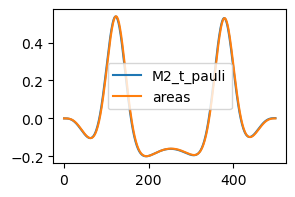

(7.544665245341497, 7.703423288656806)

In [284]:
N = len(points)
areas = [0,]
for i in range(0, N-1):
    tangent = (points[i+1] - points[i])
    areas.append(1/2 * np.cross(points[i], tangent))
areas = np.array(areas)
plt.plot(M2_t_pauli[0].imag, label='M2_t_pauli')
plt.plot(areas.real, label='areas')
plt.legend()
plt.show()

np.sum(M2_t_pauli[0].imag), np.sum(areas.real)

In [293]:
sumofareas = 0
for onearea in areas:
    sumofareas += onearea
print(sumofareas, sum(areas))

(7.703423288656803+0j) (7.703423288656803+0j)


Magnus expansion

In Hai's:
$$
\mathrm{T}\cdot\hat{\boldsymbol{\sigma}}=U_0^\dagger(t)\sigma_zU_0(t)
$$

$$
\begin{aligned}
&U_{I}(t)=I-i\delta_{j}A_{1}^{j}-[\frac{1}{2}(\delta_{j}A_{1}^{j})^{2}+i\delta_{j}\delta_{k}A_{2}^{jk}]+O(\delta^{3}),\\
&\text{where}\\
&
\left\{
    \begin{array}{c}
    A_{1}^{j}(t)=\int_{0}^{\tau}du(\mathbf{T}_{j}\cdot\hat{\boldsymbol{\sigma}})\\
    A_{2}^{jk}(t)=\frac{1}{2}\int_{0}^{t}d\tau[\dot{A}_{1}^{j}(t),A_{1}^{k}(t)]\\
    A_{n+1}^{jkl...}(t)=\frac{1}{2}\int_{0}^{t}d\tau[\dot{A}_{n}^{j}(t),A_{n}^{kl...}(t)].
    \end{array}
\right.
\end{aligned}
$$

My $M_1(t)$ is $\dot{A}_{1}^{j}(t)=\mathrm{T}\cdot\hat{\boldsymbol{\sigma}}=U_0^\dagger(t)\sigma_zU_0(t)$.

### 1.9.3. <a id='toc1_9_3_'></a>[Gradient Orthogonal Variation       ](#toc0_)

#### 1.9.3.1. <a id='toc1_9_3_1_'></a>[Orthogonalize ](#toc0_)

In [98]:
def innerProduct(a: tf.Tensor, b: tf.Tensor):
    """
    a and b are rank-1 Tensors
    """
    assert len(a.shape) == 1 and len(b.shape) == 1
    c = tf.reduce_sum(tf.math.conj(a) * b, axis=0)
    return c

def orthogonalizeTo(v, perpToW):
    """
    Assuming
    v: Tensor[L,]
    w: Tensor[L,]
    """
    w = perpToW
    v = tf.expand_dims(v, axis=1)  # column vector
    w = tf.expand_dims(w, axis=1)  # column vector
    # v = v - (v @ w) / (w @ w) * w
    v = v - tf.matmul(v, w, adjoint_a=True) / tf.matmul(w, w, adjoint_a=True) * w
    v = tf.squeeze(v, axis=1)
    return v

# This function is compatible with one `w` parameter of shape [1, L]
def orthogonalizeToMultiple(v, perpToW_s):
    """
    Assuming each vector has length L
    v: Tensor[L,]
    ws: List[Tensor[L], size=nW]
    """
    orthonormalBasis = []
    for w in perpToW_s:
        wPerp = w
        for b in orthonormalBasis:
            wPerp = wPerp - innerProduct(w, b) * b
        orthonormalW = wPerp / tf.sqrt(innerProduct(wPerp, wPerp))
        orthonormalBasis.append(orthonormalW)
    vPerp = v
    for w in orthonormalBasis:
        vPerp = vPerp - innerProduct(v, w) * w
    return vPerp

In [99]:
# # Test orthogonalizeToMultiple()
# v = tf.constant([1., 1, 1, 1], dtype=tf.float64)
# ws = tf.constant([[0., .1, 0, 8], [0, 2, 1, 2], [0, 4, 4, 4]], dtype=tf.float64)
# orthogonalizeToMultiple(v, ws)

#### 1.9.3.2. <a id='toc1_9_3_2_'></a>[GOV generic form  ](#toc0_)



$\beta$ is the angle between $dA$ and $dJ/dA$.

$dA, dA', dA^0$ are all parallel.

$$
dJ = dA \cdot \frac{dJ}{dA} = |dA| \cdot |\frac{dJ}{dA}|  \cos\beta := \Delta J
$$
hence
$$
\begin{align*}
    |dA| &= \frac{\Delta J}{|dJ/dA| \cos\beta} \\
    &= \frac{|dA'| \cdot \Delta J}{|dA'| \cdot |dJ/dA| \cos\beta} \\
    &= |dA'| \frac{\Delta J}{dA' \cdot dJ/dA}
\end{align*}
$$

In [100]:
def gradientOrthogonalVariation(x0, costAndConstraint, iters=None, alphaFixed=None, deltaJ=None):
    """
    Optimize `cost` while keeping `constraint` unchanged.
    x0: initial value that satisfies constraint condition.
    costAndConstraint: function of the form
        x -> result: dict{'cost', 'cons', **kwargs}
            containing 1 cost, nCons constraints
            result['cost']: Tensor[,] (scalar)
            result['cons']: Tensor[nCons,]
    """
    from collections import defaultdict
    result = defaultdict(lambda: [])

    x = tf.Variable(x0)
    
    for _ in tqdm(range(iters)):
        with tf.GradientTape(persistent=True) as tape:
            thisResult = costAndConstraint(x)

        result['x'].append(x.read_value())
        for k, v in thisResult.items():
            result[k].append(v)

        J = thisResult['cost']
        R = thisResult['cons']
        dJdx = tape.gradient(J, x)  # shape=(len(x),)
        dRdx = [tape.gradient(Ri, x) for Ri in R]  # shape=(nCons, len(x))
        _dx = orthogonalizeToMultiple(dJdx, dRdx)  # shape=(len(x),)
        alpha = tf.squeeze(deltaJ / innerProduct(dJdx, _dx))  # scalar
        dx = alpha * _dx

        # dJ = np.array(dJdx).conj() @ np.array(dx)
        # dR = np.array(dRdx).conj() @ np.array(dx)
        # print(f'{dx=}\n{dJdx=}\n{dJ=}\n{dR=}\n')
        x.assign_sub(dx)

    lastResult = costAndConstraint(x)
    result['x'].append(x.read_value())
    for k, v in lastResult.items():
        result[k].append(v)
    result = dict(result)
    return result

## 1.10. <a id='toc1_10_'></a>[Read $X_{1/2 \pi}$ pulse](#toc0_)


In [311]:
loadData = np.load('data/morlet_pso_0.495pi.npz')
loadData.keys()

KeysView(NpzFile 'data/morlet_pso_0.495pi.npz' with keys: pulse, tlist, Alist)

In [312]:
pulse = loadData['pulse']
tlist = loadData['tlist']
Alist = loadData['Alist']

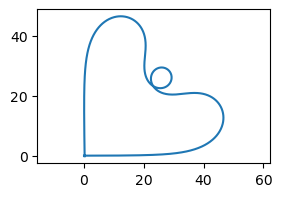

In [313]:
y, z = get_curve_fast(pulse, tlist)
plt.plot(y, z)
plt.axis('equal')
plt.show()

## 1.11. <a id='toc1_11_'></a>[Read R2=0 pulse](#toc0_)

In [317]:
with open(r'data\piOver3_R1const\tf_fromPiOver2_variableReadValue.pickle', mode='rb') as f:
    result = pickle.load(f)

In [318]:
result.keys()

dict_keys(['x', 'cost', 'cons', 'H_I_t', 'M1_t', 'tlist', 'area', 'curve_xyz'])

In [324]:
tlist = result['tlist']

minAreaIndex = 1398
A = result['x'][minAreaIndex]
x, y, z = result['curve_xyz'][minAreaIndex]

In [1]:
pulse = OldVersionMorlet(4).fromAmplitudes(A)
plt.plot(np.array(pulse).real)
plt.show()
plt.plot(y.real, z.real)
plt.show()

NameError: name 'OldVersionMorlet' is not defined

In [329]:
model = SingleControlModel(
    tlist = tf.convert_to_tensor(tlist, dtype=tf.complex128), # tlist
    H_sys = 0, # H_sys
    H_c_terms = tf.convert_to_tensor(np.array([q.sigmax().full()])), # H_c_terms
    H_n = tf.convert_to_tensor(q.sigmaz().full()), # H_n
    paramsToSinglePulse = OldVersionMorlet(4).fromAmplitudes, # paramsToPulse
)

In [ ]:
todo()

## 1.12. <a id='toc1_12_'></a>[Vary Hai's pulse with R1 fixed](#toc0_)

Hai's pulse for $R_{\mathrm{ex};\perp}^{2\pi}$ is:

`a, phi = [0.042, -0.290, -0.765, -0.274], [0.003, 0.003, 0.003]`

In [333]:
tlist = np.linspace(0, 50, 501)
a, phi = [0.042, -0.290, -0.765, -0.274], [0.003, 0.003, 0.003]
tfPulse = HaiPulse(tlist).fromParams(tf.convert_to_tensor(a + phi, dtype=tf.float64))
tfPulse.shape

TensorShape([501])

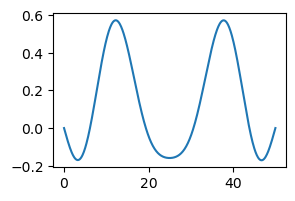

In [336]:
plt.plot(tlist, np.array(tfPulse).real)
plt.show()

In [337]:
integrate.simpson(np.array(tfPulse), x=tlist)

(6.286446383364106+0j)

In [395]:
model = SingleControlModel(
    tf.convert_to_tensor(tlist, dtype=tf.complex128), # tlist
    0, # H_sys
    tf.convert_to_tensor(np.array([q.sigmax().full()])), # H_c_terms
    tf.convert_to_tensor(q.sigmaz().full()), # H_n
    HaiPulse(tlist).fromParams, # paramsToPulse
)
Δθ = 0.001
result = gradientOrthogonalVariation(
    x0 = tf.convert_to_tensor(a + phi, dtype=tf.float64),
    costAndConstraint = model.angleAndRobustness,
    iters = int(2*np.pi/Δθ+3),
    deltaJ = Δθ,
)
result['tlist'] = tlist
result.keys()

100%|██████████| 6286/6286 [2:25:59<00:00,  1.39s/it]  


dict_keys(['x', 'cost', 'cons', 'M1_t', 'H_I_t'])

In [402]:
result['curvexyz'] = np.array(curvexyz_list)
result.keys(), result['curvexyz'].shape

(dict_keys(['x', 'cost', 'cons', 'M1_t', 'H_I_t', 'curvexyz']), (6287, 3, 501))

In [403]:
# with open('data/fromHai_R1fixed/result.pickle', mode='wb') as f:
#     pickle.dump(dict(result), f)

In [392]:
with open('data/fromHai_R1fixed/result.pickle', mode='rb') as f:
    resultLoad = pickle.load(f)

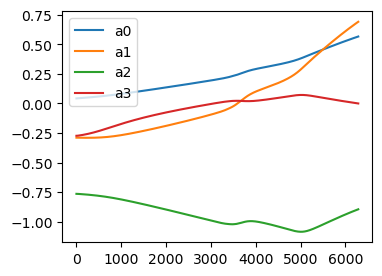

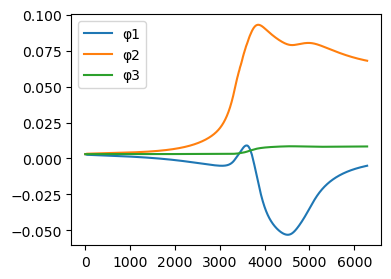

In [424]:
plt.figure(figsize=(4, 3))
plt.plot(np.array(result['x']).real[:, :4])
plt.legend('a0 a1 a2 a3'.split())
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(np.array(result['x']).real[:, 4:])
plt.legend('φ1 φ2 φ3'.split())
plt.show()

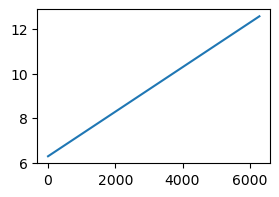

In [406]:
plt.plot(np.array(result['cost']).real)
plt.show()

In [398]:
M1_t_list = result['M1_t']
curvexyz_list = []
for k, M1_t in tqdm(enumerate(M1_t_list[::])):
    x, y, z = (
        tf.linalg.trace(M1_t @ tf.convert_to_tensor(q.sigmax().full())),
        tf.linalg.trace(M1_t @ tf.convert_to_tensor(q.sigmay().full())),
        tf.linalg.trace(M1_t @ tf.convert_to_tensor(q.sigmaz().full())),
    )
    curvexyz_list.append((x, y, z))

6287it [00:22, 277.30it/s]


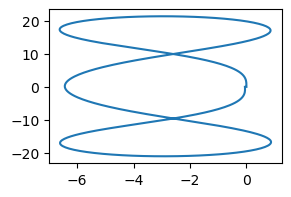

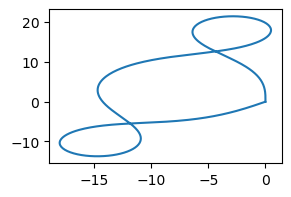

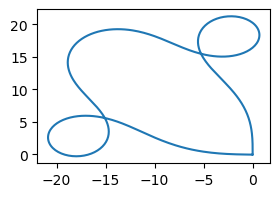

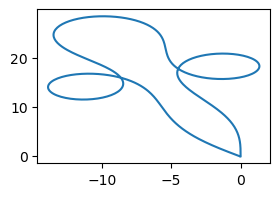

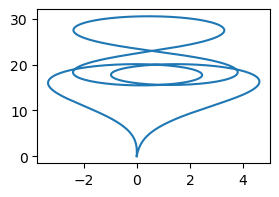

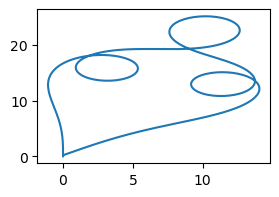

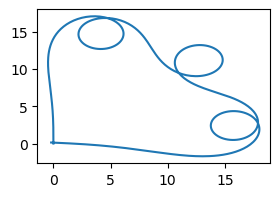

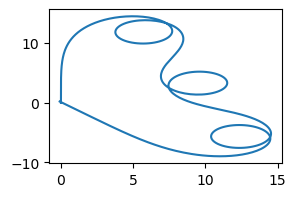

In [401]:
for x, y, z in curvexyz_list[::800]:
    x, y, z = np.array(x).real, np.array(y).real, np.array(z).real
    plt.plot(y, z)
    plt.show()

## 1.13. <a id='toc1_13_'></a>[Vary Hai's pulse with R1 R2 fixed](#toc0_)

Hai's pulse for $R_{\mathrm{ex};\perp}^{2\pi}$ is:

`a, phi = [0.042, -0.290, -0.765, -0.274], [0.003, 0.003, 0.003]`

In [105]:
tlist = np.linspace(0, 50, 501)
a, phi = [0.042, -0.290, -0.765, -0.274], [0.003, 0.003, 0.003]
tfPulse = HaiPulse(tlist).fromParams(tf.convert_to_tensor(a + phi, dtype=tf.float64))
tfPulse.shape, integrate.simpson(np.array(tfPulse), x=tlist), 2*np.pi

(TensorShape([501]), (6.286446383364106+0j), 6.283185307179586)

In [107]:
Δθ = (2*np.pi) / (3600*2)
Δθ, 2*np.pi/Δθ, (6.286446383364106-6.283185307179586) / Δθ

(0.0008726646259971648, 7200.0, 3.73691804087267)

In [108]:
a, phi = [0.042, -0.290, -0.765, -0.274], [0.003, 0.003, 0.003]
tlist = np.linspace(0, 50, 501)
model = SingleControlModel(
    tf.convert_to_tensor(tlist, dtype=tf.complex128), # tlist
    0, # H_sys
    tf.convert_to_tensor(np.array([q.sigmax().full()])), # H_c_terms
    tf.convert_to_tensor(q.sigmaz().full()), # H_n
    HaiPulse(tlist).fromParams, # paramsToPulse
)
Δθ = (2*np.pi) / (3600*2)  # rad
result = gradientOrthogonalVariation(
    x0 = tf.convert_to_tensor(a + phi, dtype=tf.float64),
    costAndConstraint = model.angleAndR1R2,
    iters = int(2*np.pi/Δθ+5),
    deltaJ = Δθ,
)
result['tlist'] = tlist

100%|██████████| 7205/7205 [5:20:10<00:00,  2.67s/it]  


In [135]:
with open('data/fromHai_R1R2fixed/result.pickle', mode='rb') as f:
    result = pickle.load(f)


In [136]:
tlist = np.linspace(0, 50, 501)
model = SingleControlModel(
    tf.convert_to_tensor(tlist, dtype=tf.complex128), # tlist
    0, # H_sys
    tf.convert_to_tensor(np.array([q.sigmax().full()])), # H_c_terms
    tf.convert_to_tensor(q.sigmaz().full()), # H_n
    HaiPulse(tlist).fromParams, # paramsToPulse
)
Δθ = -0.0004540489541233761  # rad
result = gradientOrthogonalVariation(
    x0 = result['x'][4716],
    costAndConstraint = model.angleAndR1R2,
    iters = 2,
    deltaJ = Δθ,
)
result['tlist'] = tlist

100%|██████████| 2/2 [00:05<00:00,  2.91s/it]


In [137]:
print(*(np.real(result['cost']) - np.pi/2))

-0.0004540489541233761 2.9587492456073505e-09 0.00045405486984284593


In [125]:
result.keys()

dict_keys(['x', 'cost', 'cons', 'M1_t', 'H_I_t', 'tlist', 'curvexyz'])

In [141]:
pulses = {}
pulses['a_phi'] = np.real(result['x'])
pulses['pulse'] = np.real([HaiPulse(tlist).fromParams(x) for x in result['x']])
pulses['rotationAngle'] = np.real(result['cost'])
pulses['tlist'] = np.real(result['tlist'])

In [142]:
with open('data/piOver2Gate_silicon/data.pickle', mode='wb') as f:
    pickle.dump(pulses, f)

In [132]:
with open('data/piOver2Gate_silicon/data.pickle', mode='rb') as f:
    pulses = pickle.load(f)
pulses.keys()

dict_keys(['a_phi', 'pulse', 'rotationAngle', 'tlist'])

In [124]:
result['cons']

[[<tf.Tensor: shape=(), dtype=complex128, numpy=(1.4349063103806547+0j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(10.490362134476927+0j)>],
 [<tf.Tensor: shape=(), dtype=complex128, numpy=(1.4349062235553234+0j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(10.490358058151699+0j)>],
 [<tf.Tensor: shape=(), dtype=complex128, numpy=(1.4349061366501041+0j)>,
  <tf.Tensor: shape=(), dtype=complex128, numpy=(10.49035397686486+0j)>]]

In [110]:
with open('data/fromHai_R1R2fixed7200iters/result.pickle', mode='wb') as f:
    pickle.dump(dict(result), f)

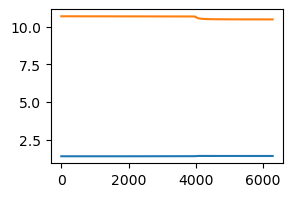

In [558]:
cons = np.array(result['cons'])
plt.plot(cons.real)

$$
\theta = \theta(a_0, \dots, a_3, \phi_1, \dots, \phi_3) = \theta(\vec{p})
$$
$$
\theta = p^0 + p^1 + p^2
$$
why R1 R2 is abruptly changing, how to potentially improve these behaviors.

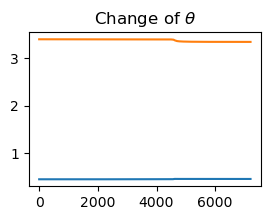

In [112]:
plt.plot(np.array(result['cons']).real / np.pi)
plt.title(r'Change of $\theta$')
plt.show()

In [113]:
result.keys()

dict_keys(['x', 'cost', 'cons', 'M1_t', 'H_I_t', 'tlist'])

In [560]:
result['M2_T'] = []
for M1_t, H_I_t in tqdm(zip(result['M1_t'], result['H_I_t'])):
    commutator = H_I_t @ M1_t - M1_t @ H_I_t
    M2_T = 1/4 * simpleIntegral(commutator, tf.cast(tlist, tf.complex128), axis=0)
    result['M2_T'].append(M2_T)


In [561]:
result['M2_T_norm'] = []
for m in tqdm(result['M2_T']):
    result['M2_T_norm'].append(tf.norm(m))

In [119]:
result['curvexyz'] = []
for M1_t in tqdm(result['M1_t']):
    x, y, z = projectToPauli(M1_t)
    result['curvexyz'].append((x, y, z))

100%|██████████| 3/3 [00:00<00:00, 85.01it/s]


In [596]:
result['area'] = []
for x, y, z in tqdm(result['curvexyz']):
    result['area'].append(net_area(np.array([y, z]).T))

  0%|          | 0/6287 [00:00<?, ?it/s]

100%|██████████| 6287/6287 [01:22<00:00, 76.08it/s]


In [530]:
x, y, z = result['curvexyz'][0]
net_area(np.array([y, z]).T)

(-7.5590848532434665+0j)

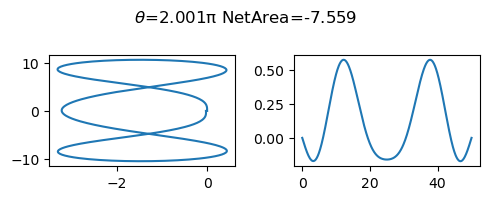

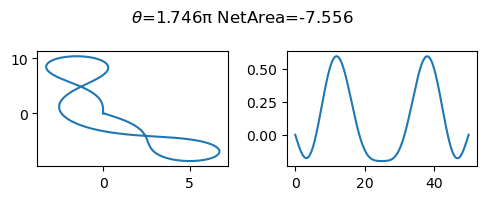

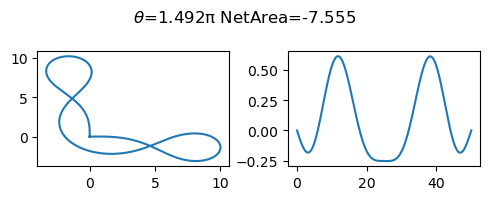

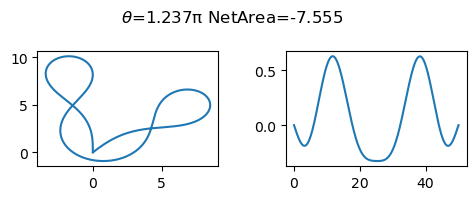

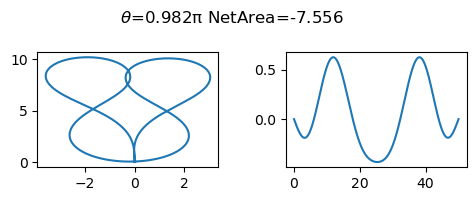

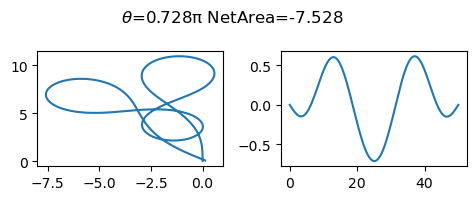

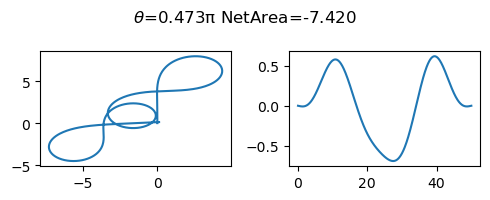

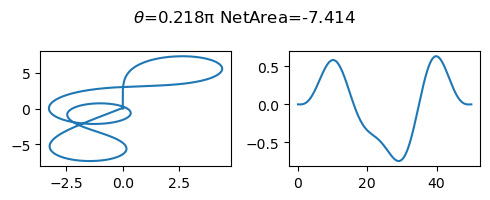

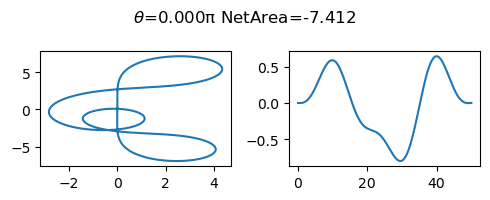

In [78]:
# plt.figure(figsize=(6,4))
hai = HaiPulse(tlist)
for k in list(range(0, len(result['x']), 800)) + [len(result['x'])-1,]:
    fig = plt.figure(figsize=(5, 2))
    ax = fig.subplots(1, 2)
    x, y, z = result['curvexyz'][k]
    x, y, z = np.array(x).real, np.array(y).real, np.array(z).real
    ax[0].plot(y, z)
    pulse = hai.fromParams(result['x'][k])
    ax[1].plot(tlist, np.array(pulse).real)
    fig.suptitle(rf"$\theta$={np.real(result['cost'][k]/np.pi):.3f}π NetArea={np.real(result['area'][k]):.3f}")
    fig.tight_layout()
    # area = net_area(np.array([y, z]).T)
    # plt.title(f'Net area = {area}')
    # fig.savefig(rf'data\fromHai_R1R2fixed\curve_and_pulse{k}.png')
plt.show()

In [77]:
result.keys()

dict_keys(['x', 'cost', 'cons', 'M1_t', 'H_I_t', 'M2_T', 'M2_T_norm', 'curvexyz', 'tlist', 'area'])

### 1.13.1. <a id='toc1_13_1_'></a>[Plot fidelity vs noise Rx Gate](#toc0_)

In [26]:
def XcZn_deltaPercentVsFidelity(pulse, progressBar=True):
    pulse = np.array(pulse).real
    maxAmp = np.max(np.abs(pulse))

    theta = integrate.simpson(pulse, x=tlist)
    gateIdeal = (-1j * q.sigmax() * theta/2).expm().full()

    deltaPercentList = np.linspace(-.2, .2, 101)
    fidelityList = []
    if progressBar:
        from tqdm import tqdm
    else:
        tqdm = lambda x: x
    for deltaPercent in tqdm(deltaPercentList):
        delta = deltaPercent * maxAmp
        H = q.QobjEvo([
            delta / 2 * q.sigmaz(),
            [q.sigmax(), pulse / 2]
        ], tlist=tlist)
        Ulist = q.propagator(H, tlist)
        fidelityList.append(matrix_similarity(Ulist[-1], gateIdeal))
    return deltaPercentList, fidelityList


In [4]:
with open('data/fromHai_R1fixed/result.pickle', mode='rb') as f:
    result = pickle.load(f)
result.keys()

dict_keys(['x', 'cost', 'cons', 'M1_t', 'H_I_t', 'curvexyz', 'tlist'])

In [36]:
# with open('data/fromHai_R1fixed/result.pickle', mode='wb') as f:
#     pickle.dump(result, f)

In [13]:
tlist = result['tlist']
hai = HaiPulse(tlist)

100%|██████████| 101/101 [00:02<00:00, 36.76it/s]


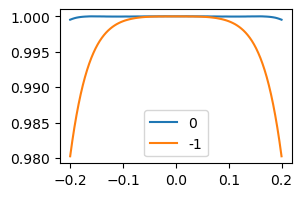

In [76]:
%matplotlib inline

noiseVsFid1 = XcZn_deltaPercentVsFidelity(hai.fromParams(result['x'][0]))
noiseVsFid2 = XcZn_deltaPercentVsFidelity(hai.fromParams(result['x'][-1]))
plt.plot(*noiseVsFid1)
plt.plot(*noiseVsFid2)
plt.legend('0 -1'.split())
plt.show()

100%|██████████| 630/630 [20:07<00:00,  1.92s/it]


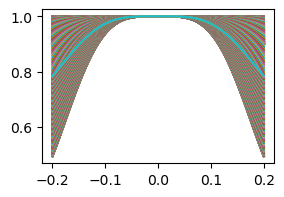

In [630]:
# Load RIPV result
with open('data/fromHai_R1fixed/result.pickle', mode='rb') as f:
    result = pickle.load(f)

noiseFid_list = []
for k in tqdm(list(range(0, len(result['x']), 10)) + [len(result['x'])-1,]):
    noiseVsFid = XcZn_deltaPercentVsFidelity(hai.fromParams(result['x'][k]), progressBar=False)
    noiseFid_list.append(noiseVsFid)

# Write noise vs. fidelity data
# with open(r'data\fromHai_R1fixed\noiseVSFid.pickle', mode='wb') as f:
#     pickle.dump(curves, f)

In [27]:
# Load RIPV result
with open('data/fromHai_R1R2fixed/result.pickle', mode='rb') as f:
    result = pickle.load(f)

noiseFid_list = []
for k in tqdm(list(range(0, len(result['x']), 10)) + [len(result['x'])-1,]):
    noiseVsFid = XcZn_deltaPercentVsFidelity(hai.fromParams(result['x'][k]), progressBar=False)
    noiseFid_list.append(noiseVsFid)

# Write noise vs. fidelity data
with open(r'data\fromHai_R1R2fixed\noiseVSFid.pickle', mode='wb') as f:
    pickle.dump(noiseFid_list, f)

100%|██████████| 630/630 [14:57<00:00,  1.42s/it]


In [59]:
with open(r'data\fromHai_R1fixed\noiseVSFid.pickle', mode='rb') as f:
    noiseFid_list = pickle.load(f)
len(noiseFid_list)

630

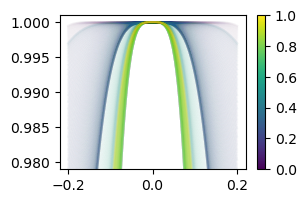

In [61]:
%matplotlib inline
from matplotlib.pyplot import cm

cmap = cm.viridis
color = cmap(np.linspace(0, 1, len(noiseFid_list)))
for i, c in enumerate(color[:]):
   plt.plot(*noiseFid_list[i], c=c, alpha=.02)
plt.ylim(.979, 1.001)
plt.colorbar(cm.ScalarMappable(cmap=cmap), ax=plt.gca())
plt.show()

In [157]:
len(result['x']), len(noiseFid_list)

(6287, 630)

In [46]:
%matplotlib inline

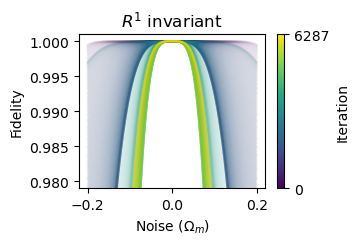

In [62]:
from matplotlib.pyplot import cm
from matplotlib.colors import Normalize

# cmap = cm.PiYG
cmap = cm.viridis
color = cmap(np.linspace(0, 1, len(noiseFid_list)))
for i, c in enumerate(color[:]):
   plt.plot(*noiseFid_list[i], c=c, alpha=.04)
plt.ylim(.979, 1.001)
cbar = plt.colorbar(cm.ScalarMappable(Normalize(0, 6287), cmap=cmap), ax=plt.gca(), ticks=[0, 6287])
cbar.ax.set_ylabel('Iteration')
plt.title(r'$R^1$ invariant')
plt.xlabel(r'Noise ($\Omega_m$)')
plt.ylabel('Fidelity')
plt.show()

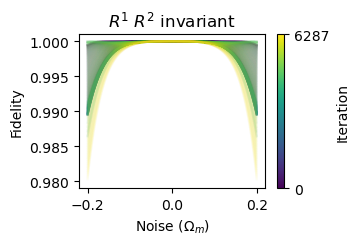

In [ ]:
from matplotlib.pyplot import cm
from matplotlib.colors import Normalize

# cmap = cm.PiYG
cmap = cm.viridis
color = cmap(np.linspace(0, 1, len(noiseFid_list)))
for i, c in enumerate(color[:]):
   plt.plot(*noiseFid_list[i], c=c, alpha=.04)
plt.ylim(.979, 1.001)
cbar = plt.colorbar(cm.ScalarMappable(Normalize(0, 6287), cmap=cmap), ax=plt.gca(), ticks=[0, 6287])
cbar.ax.set_ylabel('Iteration')
plt.title(r'$R^1$ $R^2$ invariant')
plt.xlabel(r'Noise ($\Omega_m$)')
plt.ylabel('Fidelity')
plt.show()

#### 1.13.1.1. <a id='toc1_13_1_1_'></a>[3D plottings](#toc0_)

In [7]:
LENGTH = len(result['x'])
cmap = cm.viridis
color = cmap(np.linspace(0, 1, LENGTH))

In [ ]:
len(result['x']), len(curvexyz_list)

In [17]:
%matplotlib

curvexyz_list = result['curvexyz']

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(projection='3d')

highlighted = set(np.linspace(0, LENGTH-1, 7, dtype=np.int32))

for index in np.linspace(0, LENGTH-1, 67, dtype=np.int32):
    x, y, z = curvexyz_list[index]
    x, y, z = np.array(x).real, np.array(y).real, np.array(z).real
    if index in highlighted:
        ax.plot(np.ones(z.shape) * index, y, z, color=color[index])
    else:
        ax.plot(np.ones(z.shape) * index, y, z, color=color[index], alpha=.2)
ax.set_box_aspect((2.5, 1, 1))
ax.set_xlabel('\nIteration (Total 6287)')
ax.set_ylabel(r'$\sigma_y$ error')
ax.set_zlabel(r'$\sigma_z$ error')
ax.set_aspect('equalyz')
ticks = [-7.5, 0, 10]
ax.set_yticks(ticks=ticks, labels=ticks)
fig.tight_layout()
plt.show()

Using matplotlib backend: QtAgg


C:\Users\neohu\AppData\Local\Temp\ipykernel_9308\3883257303.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


In [18]:
%matplotlib qt

x_list = result['x']
tlist = result['tlist']

fig = plt.figure(figsize=(15, 6), constrained_layout=True)
ax = fig.add_subplot(projection='3d')

highlighted = set(np.linspace(0, LENGTH-1, 7, dtype=np.int32))

for index in np.linspace(0, LENGTH-1, 67, dtype=np.int32):
    A = x_list[index]
    pulse = hai.fromParams(A)
    pulse = np.real(pulse)
    if index in highlighted:
        ax.plot(np.ones(tlist.shape) * index, tlist, pulse, color=color[index])
    else:
        ax.plot(np.ones(tlist.shape) * index, tlist, pulse, color=color[index], alpha=.2)
# plt.axis('equal')
# plt.legend()
# plt.savefig('data/piOver3_R1const/error_curves.png')
ax.set_box_aspect((2.5, 1, 1))
ax.set_xlabel('\n\nIteration (Total 6287)')
ax.set_ylabel('Time (ns)')
ax.set_zlabel('\nAmplitude (GHz)')
tickLabels = [0, 25, 50]
ticks = [int(t) for t in tickLabels]
ax.set_yticks(tickLabels, tickLabels)
# fig.constrained_layout()
plt.show()

c:\Users\neohu\.conda\envs\tf\lib\site-packages\ipykernel\eventloops.py:128: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  el.exec() if hasattr(el, "exec") else el.exec_()


In [24]:
highlighted

{0, 1047, 2095, 3143, 4190, 5238, 6286}

### 1.13.2. <a id='toc1_13_2_'></a>[Plot fidelity vs detuning in iSWAP](#toc0_)

In [72]:
q.tensor([q.sigmaz(), q.identity(2)][::1]) - q.tensor([q.sigmaz(), q.identity(2)][::-1])

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.  0.  0.  0.]
 [ 0.  2.  0.  0.]
 [ 0.  0. -2.  0.]
 [ 0.  0.  0.  0.]]

In [57]:
q.tensor([q.sigmaz(), q.identity(2)][::-1])

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]

In [4]:
with open('data/fromHai_R1R2fixed/result.pickle', mode='rb') as f:
    result = pickle.load(f)
result.keys()

dict_keys(['x', 'cost', 'cons', 'M1_t', 'H_I_t', 'M2_T', 'M2_T_norm', 'curvexyz', 'tlist', 'area'])

In [24]:
def plot_iSWAPfid_detuningNoise(pulse, progressBar=True):
    pulse = np.array(pulse).real
    maxAmp = np.max(np.abs(pulse))

    X, Y, Z, I = q.sigmax(), q.sigmay(), q.sigmaz(), q.identity(2)
    XX_plus_YY = (q.tensor([X, X]) + q.tensor([Y, Y]))
    ZI_minus_IZ = (q.tensor([Z, I]) - q.tensor([I, Z]))# * 1/2
    # XX_plus_YY = X
    # ZI_minus_IZ = Z

    thetaIdeal = integrate.simpson(pulse, x=tlist)
    gateIdeal = (-1j * XX_plus_YY * thetaIdeal/4).expm().full()

    deltaPercentList = np.linspace(-.2, .2, 101)
    fidelityList = []
    if progressBar:
        from tqdm import tqdm
    else:
        tqdm = lambda x: x
    for deltaPercent in tqdm(deltaPercentList):
        delta = deltaPercent * maxAmp
        H = q.QobjEvo([
            delta / 4 * ZI_minus_IZ,  # noise
            [XX_plus_YY, pulse / 4],  # drive
        ], tlist=tlist)
        Ulist = q.propagator(H, tlist)
        # print(Ulist[-1], gateIdeal, sep='\n', end='\n\n')
        # correction = (-1j * -delta / 2 * ZI * tlist[-1]).expm().full()
        fidelityList.append(matrix_similarity(Ulist[-1], gateIdeal))
    return deltaPercentList, fidelityList


100%|██████████| 101/101 [00:01<00:00, 75.24it/s]


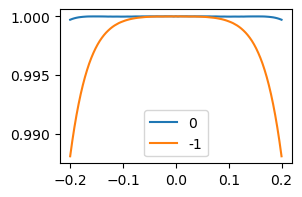

In [23]:
tlist = result['tlist']
hai = HaiPulse(tlist)

noiseVsFid1 = plot_iSWAPfid_detuningNoise(hai.fromParams(result['x'][0]))
noiseVsFid2 = plot_iSWAPfid_detuningNoise(hai.fromParams(result['x'][-1]))
plt.plot(*noiseVsFid1)
plt.plot(*noiseVsFid2)
plt.legend('0 -1'.split())
plt.show()

In [60]:
noiseVsFid_list = []
for k in tqdm(list(range(0, len(result['x']), 10)) + [len(result['x'])-1,]):
    noiseVsFid = plot_iSWAPfid_detuningNoise(hai.fromParams(result['x'][k]), progressBar=False)
    noiseVsFid_list.append(noiseVsFid)

100%|██████████| 630/630 [14:37<00:00,  1.39s/it]


In [61]:
# Write noise vs. fidelity data
with open(r'data\fromHai_R1R2fixed\noiseVSFid_iSWAP.pickle', mode='wb') as f:
    pickle.dump(noiseVsFid_list, f)

In [25]:
# Load two files for comparison
with open(r'data\fromHai_R1R2fixed\noiseVSFid.pickle', mode='rb') as f:
    noiseVsFid_list = pickle.load(f)
len(noiseVsFid_list)
with open(r'data\fromHai_R1R2fixed\noiseVSFid_iSWAP.pickle', mode='rb') as f:
    noiseVsFid_list_iSWAP = pickle.load(f)
len(noiseVsFid_list_iSWAP)

630

c:\Users\neohu\.conda\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py:1062: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


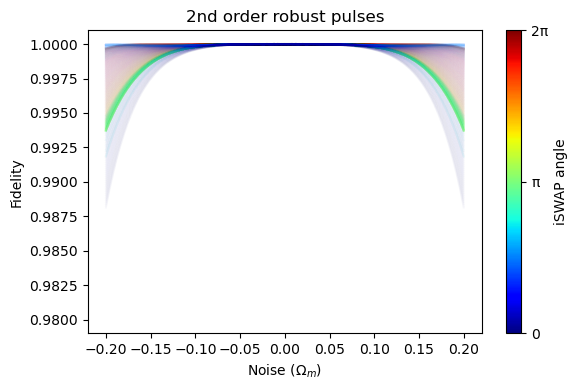

In [111]:
# Prepare indices because we extract a sub-array of result['x']
indices = list(range(0, len(result['x']), 10)) + [len(result['x'])-1,]
angles = np.array(result['cost'], dtype=np.float64)[indices]

cmap = cm.jet
colorNormalizer = mpl.colors.Normalize(0, 2*np.pi)

plt.figure(figsize=(6, 4))
for data, angle in zip(noiseVsFid_list_iSWAP, angles):
   plt.plot(*data, c=cmap(colorNormalizer(angle)), alpha=.02)
plt.ylim(.979, 1.001)
plt.ylabel('Fidelity')
plt.xlabel(r'Noise ($\Omega_m$)')
plt.title('2nd order robust pulses')
cbar = plt.colorbar(cm.ScalarMappable(colorNormalizer, cmap=cmap), ax=plt.gca())
cbar.set_label('iSWAP angle')  # Set the label for the colorbar
cbar.set_ticks([0, np.pi, 2*np.pi])  # Specify custom tick positions
cbar.set_ticklabels('0 π 2π'.split())  # Set custom tick labels
plt.tight_layout()
plt.savefig(r'data\fromHai_R1R2fixed\_noiseFid_iSWAP_stacked')
plt.show()

c:\Users\neohu\.conda\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py:1062: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


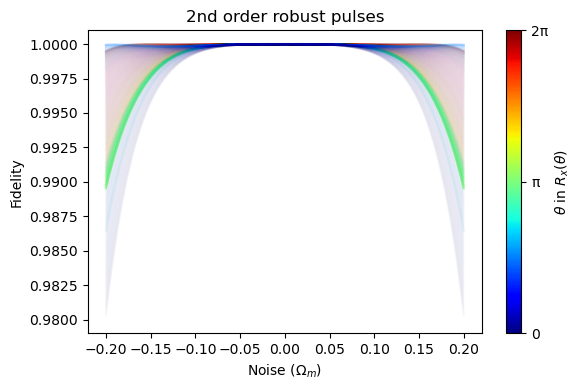

In [28]:
# Prepare indices because we extract a sub-array of result['x']
indices = list(range(0, len(result['x']), 10)) + [len(result['x'])-1,]
angles = np.array(result['cost'], dtype=np.float64)[indices]

cmap = cm.jet
colorNormalizer = mpl.colors.Normalize(0, 2*np.pi)

plt.figure(figsize=(6, 4))
for data, angle in zip(noiseVsFid_list, angles):
   plt.plot(*data, c=cmap(colorNormalizer(angle)), alpha=.02)
plt.ylim(.979, 1.001)
plt.ylabel('Fidelity')
plt.xlabel(r'Noise ($\Omega_m$)')
plt.title('2nd order robust pulses')
cbar = plt.colorbar(cm.ScalarMappable(colorNormalizer, cmap=cmap), ax=plt.gca())
cbar.set_label(r'$\theta$ in $R_x(\theta)$')  # Set the label for the colorbar
cbar.set_ticks([0, np.pi, 2*np.pi])  # Specify custom tick positions
cbar.set_ticklabels('0 π 2π'.split())  # Set custom tick labels
plt.tight_layout()
plt.savefig(r'data\fromHai_R1R2fixed\_noiseFid_stacked')
plt.show()

### 1.13.3. <a id='toc1_13_3_'></a>[Animation](#toc0_)

In [102]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np

import matplotlib.animation as animation

def animateCurveSeries(curves, filename, pbar, fig, ax, colorMap=cm.hsv):
    """
    Each curves[i] is shape(2, nPoints) array
    """

    color = colorMap(np.linspace(0, 1, len(curves)))
    line, = ax.plot(*curves[0], c=color[0])

    # pbar = tqdm(len(curves))

    def animate(i):
        pbar.update(1)
        line.set_xdata(curves[i][0])
        line.set_ydata(curves[i][1])
        line.set_color(color[i])
        return line,


    ani = animation.FuncAnimation(
        fig, animate, interval=20, blit=True, save_count=len(curves))
    writervideo = animation.FFMpegWriter(fps=60)
    ani.save(filename, writer=writervideo)
    print('file saved at', filename)
    return

In [98]:
with open('data/fromHai_R1R2fixed/result.pickle', mode='rb') as f:
    result = pickle.load(f)


1it [26:18, 1578.54s/it]
511it [25:59,  3.05s/it]
69it [24:24, 21.23s/it]
221it [24:05,  6.54s/it]
97it [22:52, 14.15s/it]
Exception ignored in: <function tqdm.__del__ at 0x0000025A6CE07280>
Traceback (most recent call last):
  File "c:\Users\neohu\.conda\envs\tf\lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\neohu\.conda\envs\tf\lib\site-packages\tqdm\notebook.py", line 282, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x0000025A6CE07280>
Traceback (most recent call last):
  File "c:\Users\neohu\.conda\envs\tf\lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\neohu\.conda\envs\tf\lib\site-packages\tqdm\notebook.py", line 282, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function

In [75]:
pbar = tqdm(10)
from time import sleep
for i in range(10):
    sleep(.1)
    pbar.update(1)
pbar.close()

10it [00:01,  9.23it/s]


In [99]:
noiseFid_list = result['curvexyz'][::10] + [result['curvexyz'][-1],]


633it [02:30,  4.21it/s]00:00<?, ?it/s]
631it [00:23, 25.42it/s]                         

file saved at data/fromHai_R1R2fixed/error_curves.mp4


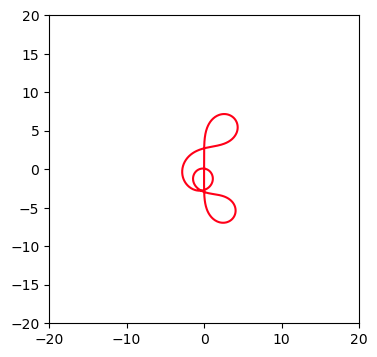

633it [00:38, 25.42it/s]

In [104]:
from tqdm import tqdm

fig = plt.figure(figsize=(4, 4))
ax = fig.subplots()
ax.set_ylim(-20, 20)
ax.set_xlim(-20, 20)
animateCurveSeries(
    [np.real((y, z)) for x, y, z in noiseFid_list],
    'data/fromHai_R1R2fixed/error_curves.mp4',
    tqdm(total=len(noiseFid_list), position=0, leave=True),
    fig, ax,
)

c:\Users\neohu\.conda\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py:1062: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())
c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


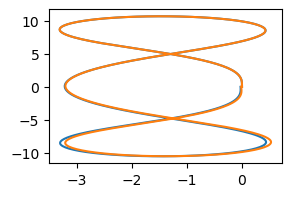

In [100]:
for x, y, z in noiseFid_list[:2]:
    plt.plot(y, z)
plt.show()

c:\Users\neohu\.conda\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py:1062: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())
c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


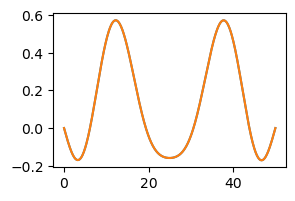

In [93]:
tlist = np.linspace(0, 50, 501)
hai = HaiPulse(tlist)
for A in result['x'][:2]:
    pulse = hai.fromParams(A)
    plt.plot(tlist, pulse)
plt.show()